# Growth of Sequence Read Archive

The plots here visualize the growth of NCBI's [Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra/docs/sragrowth/) over the past 10+ years.


In [1]:
%pylab inline
import pandas as pd
import proplot
import seaborn as sns

import humanfriendly

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv("../sra_stat.csv")
df.date = pd.to_datetime(df.date)
cols = ["bases", "open_access_bases", "bytes", "open_access_bytes"]
for col in cols:
    df["log({})".format(col)] = np.log10(df[col])
df["diff_days"] = (df.date.diff()) / np.timedelta64(1, "D")
df["diff_months"] = (df.date.diff()) / np.timedelta64(1, "M")
df["diff_bytes"] = df.bytes.diff()
df["diff_logbytes"] = df["log(bytes)"].diff()

df["rate_bytes_months"] = df["diff_bytes"] / df["diff_months"]
df["rate_bytes_days"] = df["diff_bytes"] / df["diff_days"]
df["rate_logbytes_days"] = df["diff_logbytes"] / df["diff_days"]
df["rate_logbytes_days_mean"] = (
    df["rate_logbytes_days"].rolling(360, center=True).mean()
)

df["diff_open_access_bytes"] = df.open_access_bytes.diff()
df["diff_logopen_access_bytes"] = df["log(open_access_bytes)"].diff()

df["rate_open_access_bytes_months"] = df["diff_open_access_bytes"] / df["diff_months"]
df["rate_open_access_bytes_days"] = df["diff_open_access_bytes"] / df["diff_days"]
df["rate_logopen_access_bytes_days"] = df["diff_logopen_access_bytes"] / df["diff_days"]
df["rate_logopen_access_bytes_days_mean"] = (
    df["rate_logopen_access_bytes_days"].rolling(360, center=True).mean()
)

df.head()

,date,bases,open_access_bases,bytes,open_access_bytes,log(bases),log(open_access_bases),log(bytes),log(open_access_bytes),diff_days,...,rate_bytes_months,rate_bytes_days,rate_logbytes_days,rate_logbytes_days_mean,diff_open_access_bytes,diff_logopen_access_bytes,rate_open_access_bytes_months,rate_open_access_bytes_days,rate_logopen_access_bytes_days,rate_logopen_access_bytes_days_mean
0,2007-06-05,20304190150,20304190150,50496285115,50496285115,10.307586,10.307586,10.703259,10.703259,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-04-04,39753724527,39753724527,98578509466,98578509466,10.599378,10.599378,10.993782,10.993782,304.0,...,4.814055e+09,1.581652e+08,0.000956,NaN,4.808222e+10,0.290523,4.814055e+09,1.581652e+08,0.000956,NaN
2,2008-04-05,41358022149,41358022149,102560743983,102560743983,10.616560,10.616560,11.010981,11.010981,1.0,...,1.212068e+11,3.982235e+09,0.017199,NaN,3.982235e+09,0.017199,1.212068e+11,3.982235e+09,0.017199,NaN
3,2008-04-09,41807184131,41807184131,103698289223,103698289223,10.621251,10.621251,11.015772,11.015772,4.0,...,8.655831e+09,2.843863e+08,0.001198,NaN,1.137545e+09,0.004790,8.655831e+09,2.843863e+08,0.001198,NaN
4,2008-04-15,41932946619,41932946619,104004397361,104004397361,10.622555,10.622555,11.017052,11.017052,6.0,...,1.552829e+09,5.101802e+07,0.000213,NaN,3.061081e+08,0.001280,1.552829e+09,5.101802e+07,0.000213,NaN


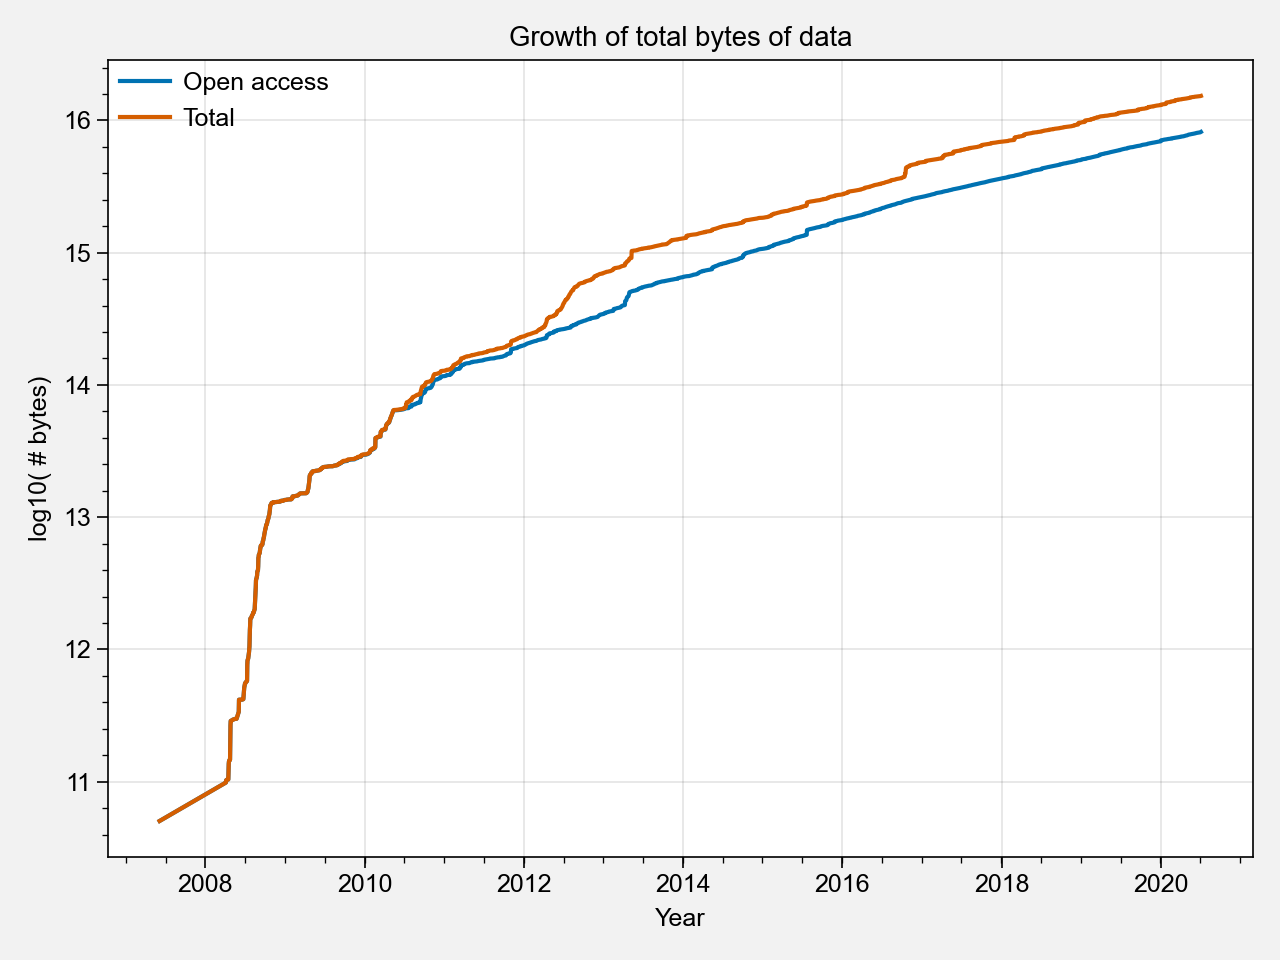

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="log(open_access_bytes)", data=df, ax=ax, label="Open access")
sns.lineplot(x="date", y="log(bytes)", data=df, ax=ax, label="Total")
ax.set_ylabel("log10( # bytes)")
ax.set_xlabel("Year")
ax.legend(frameon=False)
ax.set_title("Growth of total bytes of data")
fig.tight_layout()
fig.savefig('./plots/SraStats-growth.png', dpi=300)

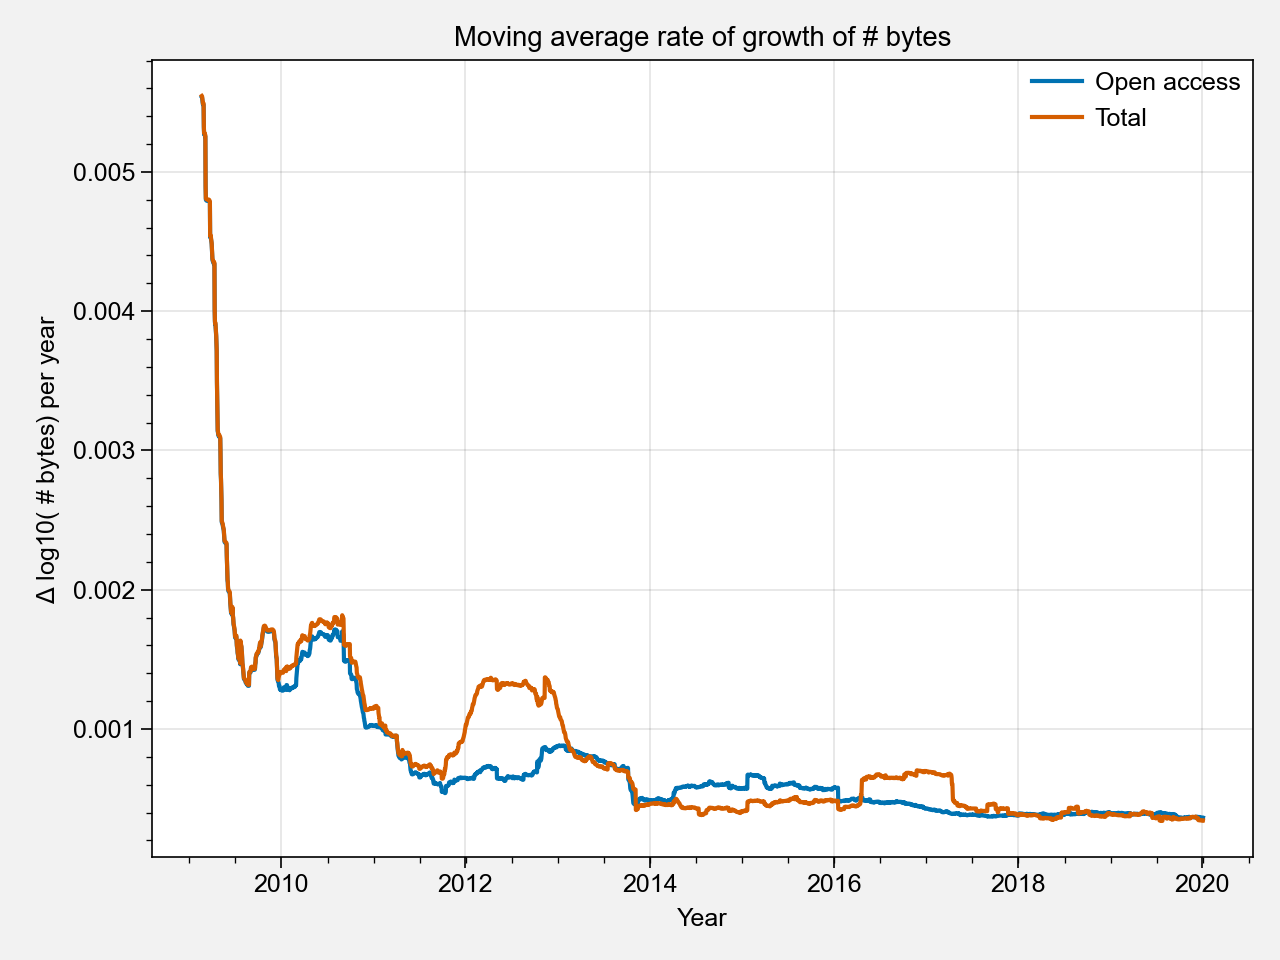

In [4]:
fig, ax = plt.subplots()
sns.lineplot(
    x="date",
    y="rate_logopen_access_bytes_days_mean",
    data=df,
    ax=ax,
    label="Open access",
)
sns.lineplot(x="date", y="rate_logbytes_days_mean", data=df, ax=ax, label="Total")

ax.set_title("Moving average rate of growth of # bytes")
ax.set_xlabel("Year")
ax.set_ylabel(r"$\Delta$ log10( # bytes) per year")
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('./plots/SraStats-movingavg.png', dpi=300)

In [5]:
def get_doubling_times(col, starting_size=8e15, stop_size=1e12, out=False):

    doubling_times = []

    current_size = starting_size
    sizes = []
    while current_size > stop_size:
        current_date = df.loc[np.where(df[col] >= current_size)[0][0], "date"]
        half_size = current_size / 2
        half_date = df.loc[np.where(df[col] >= half_size)[0][0], "date"]

        difference = (current_date - half_date) / np.timedelta64(1, "M")
        if out:
            print(
                "{} to {} in: {} months".format(
                    humanfriendly.format_size(half_size),
                    humanfriendly.format_size(current_size),
                    int(np.ceil(difference)),
                )
            )

        sizes.append(current_size)
        doubling_times.append(int(np.ceil(difference)))
        current_size = half_size
    return sizes, doubling_times


sizes, doubling_times = get_doubling_times("bytes", 15e15, 1e11)
open_sizes, open_doubling_times = get_doubling_times("open_access_bytes")

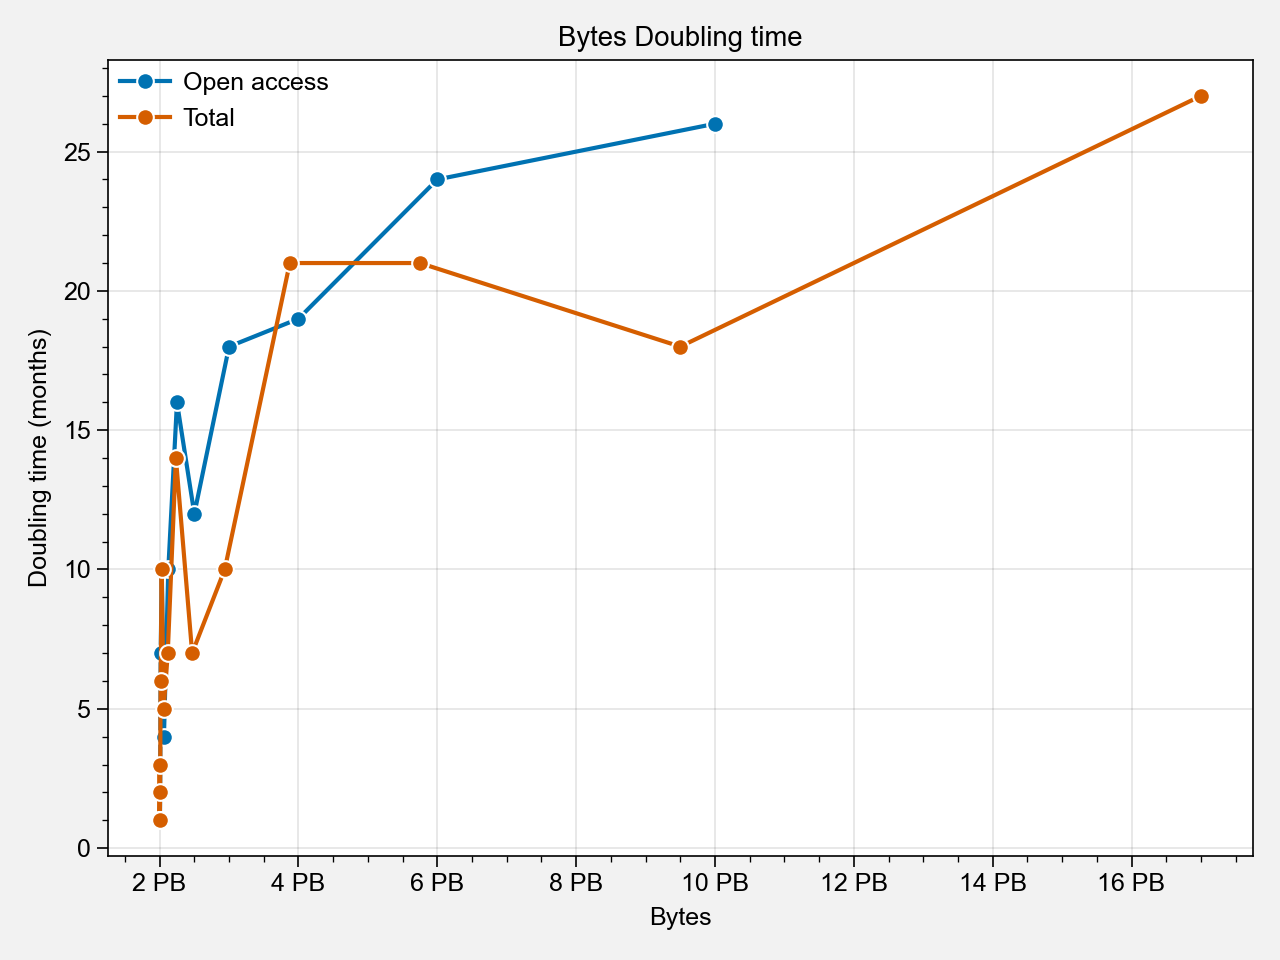

In [6]:
fig, ax = plt.subplots()
sns.lineplot(open_sizes, open_doubling_times, ax=ax, label="Open access", marker="o")
sns.lineplot(sizes, doubling_times, ax=ax, label="Total", marker="o")
ax.set_xlabel("Bytes")
ax.set_ylabel("Doubling time (months)")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
ticklabels = [humanfriendly.format_size(int(x)) for x in list(ax.get_xticks())]
ax.set_xticklabels(ticklabels[1:])
ax.legend(frameon=False)
ax.set_title("Bytes Doubling time")
fig.tight_layout()
fig.savefig('./plots/SraStats-movingavg.png', dpi=300)
plt.show()